# LSTM IDS Dataset Internet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import LabelEncoder
import nltk
from sklearn.model_selection import train_test_split
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import time

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## *Preprocessing*

### *Import Data*

In [ ]:
df_data = pd.read_csv('gdrive/My Drive/TA/DoS.csv')
df_data.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_invalid,frame.time_relative,ip.src,ip.dst,tcp.srcport,tcp.dstport,eth.src,eth.dst,frame.cap_len,frame.coloring_rule.name,frame.coloring_rule.string,frame.comment,frame.comment.expert,frame.encap_type,frame.file_off,frame.ignored,frame.incomplete,frame.interface_id,frame.interface_name,frame.len,frame.link_nr,frame.marked,frame.md5_hash,frame.number,frame.offset_shift,mqtt.clientid,mqtt.clientid_len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.uname,mqtt.conflag.willflag,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.passwd,mqtt.passwd_len,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.topic,mqtt.topic_len,mqtt.username,mqtt.username_len,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,type
0,0.000000,0.000000,1.522235e+09,NaN,0.000000,192.168.1.1,192.168.1.196,22.0,51749.0,18:a6:f7:eb:77:26,30:5a:3a:62:72:80,122,NaN,NaN,NaN,NaN,1,NaN,0,NaN,NaN,NaN,122,NaN,0,NaN,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
1,0.001922,0.001922,1.522235e+09,NaN,0.001922,192.168.1.1,192.168.1.196,22.0,51749.0,18:a6:f7:eb:77:26,30:5a:3a:62:72:80,190,NaN,NaN,NaN,NaN,1,NaN,0,NaN,NaN,NaN,190,NaN,0,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
2,0.001010,0.001010,1.522235e+09,NaN,0.002932,192.168.1.196,192.168.1.1,51749.0,22.0,30:5a:3a:62:72:80,18:a6:f7:eb:77:26,54,NaN,NaN,NaN,NaN,1,NaN,0,NaN,NaN,NaN,54,NaN,0,NaN,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
3,0.008597,0.008597,1.522235e+09,NaN,0.011529,192.168.1.1,192.168.1.196,22.0,51749.0,18:a6:f7:eb:77:26,30:5a:3a:62:72:80,186,NaN,NaN,NaN,NaN,1,NaN,0,NaN,NaN,NaN,186,NaN,0,NaN,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
4,0.002925,0.002925,1.522235e+09,NaN,0.014454,192.168.1.196,192.168.1.1,51749.0,22.0,30:5a:3a:62:72:80,18:a6:f7:eb:77:26,54,NaN,NaN,NaN,NaN,1,NaN,0,NaN,NaN,NaN,54,NaN,0,NaN,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94625 entries, 0 to 94624
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   frame.time_delta            94625 non-null  float64
 1   frame.time_delta_displayed  94625 non-null  float64
 2   frame.time_epoch            94625 non-null  float64
 3   frame.time_invalid          0 non-null      float64
 4   frame.time_relative         94625 non-null  float64
 5   ip.src                      93592 non-null  object 
 6   ip.dst                      93592 non-null  object 
 7   tcp.srcport                 88460 non-null  float64
 8   tcp.dstport                 88460 non-null  float64
 9   eth.src                     94625 non-null  object 
 10  eth.dst                     94625 non-null  object 
 11  frame.cap_len               94625 non-null  int64  
 12  frame.coloring_rule.name    0 non-null      float64
 13  frame.coloring_rule.string  0 n

### Drop Kolom yang Memiliki *Missing Value* mendekati 100%

In [ ]:
print (df_data.isnull().sum())

frame.time_delta                  0
frame.time_delta_displayed        0
frame.time_epoch                  0
frame.time_invalid            94625
frame.time_relative               0
                              ...  
mqtt.willmsg                  94625
mqtt.willmsg_len              94625
mqtt.willtopic                94625
mqtt.willtopic_len            94625
type                              0
Length: 67, dtype: int64


In [ ]:
df_data.drop(['frame.time_invalid','frame.coloring_rule.name', 'frame.coloring_rule.string', 'frame.comment', 'frame.comment.expert', 'frame.file_off', 'frame.incomplete', 'frame.interface_id', 'frame.interface_name', 'frame.link_nr', 'frame.md5_hash', 'mqtt.passwd', 'mqtt.passwd_len', 'mqtt.username', 'mqtt.username_len', 'mqtt.willmsg', 'mqtt.willmsg_len', 'mqtt.willtopic', 'mqtt.willtopic_len'], axis=1, inplace = True)
print (df_data.isnull().sum())

frame.time_delta                  0
frame.time_delta_displayed        0
frame.time_epoch                  0
frame.time_relative               0
ip.src                         1033
ip.dst                         1033
tcp.srcport                    6165
tcp.dstport                    6165
eth.src                           0
eth.dst                           0
frame.cap_len                     0
frame.encap_type                  0
frame.ignored                     0
frame.len                         0
frame.marked                      0
frame.number                      0
frame.offset_shift                0
mqtt.clientid                 94302
mqtt.clientid_len             94302
mqtt.conack.flags             93855
mqtt.conack.flags.reserved    93855
mqtt.conack.flags.sp          93855
mqtt.conack.val               93855
mqtt.conflag.cleansess        94302
mqtt.conflag.passwd           94302
mqtt.conflag.qos              94302
mqtt.conflag.reserved         94302
mqtt.conflag.retain         

In [ ]:
df_data.drop(['mqtt.clientid','mqtt.clientid_len', 'mqtt.conack.flags', 'mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.uname', 'mqtt.conflag.willflag', 'mqtt.conflags', 'mqtt.kalive', 'mqtt.msgid', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.ver'], axis=1, inplace = True)
print (df_data.isnull().sum())

frame.time_delta                  0
frame.time_delta_displayed        0
frame.time_epoch                  0
frame.time_relative               0
ip.src                         1033
ip.dst                         1033
tcp.srcport                    6165
tcp.dstport                    6165
eth.src                           0
eth.dst                           0
frame.cap_len                     0
frame.encap_type                  0
frame.ignored                     0
frame.len                         0
frame.marked                      0
frame.number                      0
frame.offset_shift                0
mqtt.dupflag                  56161
mqtt.hdrflags                 55090
mqtt.len                      55090
mqtt.msg                      56892
mqtt.msgtype                  55090
mqtt.qos                      56161
mqtt.retain                   56161
mqtt.topic                    56888
mqtt.topic_len                56157
type                              0
dtype: int64


### Mengubah Kolom *Type* Menjadi Numerik

In [ ]:
le = LabelEncoder()
 
df_data['type']= le.fit_transform(df_data['type'])
df_data['frame.encap_type']= le.fit_transform(df_data['frame.encap_type'])

print(df_data['type'])

0        1
1        1
2        1
3        1
4        1
        ..
94620    1
94621    1
94622    1
94623    1
94624    1
Name: type, Length: 94625, dtype: int64


### Mengisi *Missing Value* dengan *Mean*, *Modus*, dan *Replace* dengan *Value* 0

In [ ]:
df_data['ip.src'] = df_data['ip.src'].fillna(df_data['ip.src'].mode()[0])
df_data['ip.dst'] = df_data['ip.dst'].fillna(df_data['ip.dst'].mode()[0])
df_data['tcp.srcport'] = df_data['tcp.srcport'].fillna(df_data['tcp.srcport'].mean())
df_data['tcp.dstport'] = df_data['tcp.dstport'].fillna(df_data['tcp.dstport'].mean())
df_data['mqtt.dupflag'] = df_data['mqtt.dupflag'].fillna(0)
df_data['mqtt.hdrflags'] = df_data['mqtt.hdrflags'].fillna(0)
df_data['mqtt.len'] = df_data['mqtt.len'].fillna(0)
df_data['mqtt.msg'] = df_data['mqtt.msg'].fillna(0)
df_data['mqtt.msgtype'] = df_data['mqtt.msgtype'].fillna(0)
df_data['mqtt.qos'] = df_data['mqtt.qos'].fillna(0)
df_data['mqtt.retain'] = df_data['mqtt.retain'].fillna(0)
df_data['mqtt.topic'] = df_data['mqtt.topic'].fillna(0)
df_data['mqtt.topic_len'] = df_data['mqtt.topic_len'].fillna(0)

print(df_data.isna().sum())

frame.time_delta              0
frame.time_delta_displayed    0
frame.time_epoch              0
frame.time_relative           0
ip.src                        0
ip.dst                        0
tcp.srcport                   0
tcp.dstport                   0
eth.src                       0
eth.dst                       0
frame.cap_len                 0
frame.encap_type              0
frame.ignored                 0
frame.len                     0
frame.marked                  0
frame.number                  0
frame.offset_shift            0
mqtt.dupflag                  0
mqtt.hdrflags                 0
mqtt.len                      0
mqtt.msg                      0
mqtt.msgtype                  0
mqtt.qos                      0
mqtt.retain                   0
mqtt.topic                    0
mqtt.topic_len                0
type                          0
dtype: int64


### Mengubah *Value* Kolom yang Berupa *Object* menjadi Numerik

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94625 entries, 0 to 94624
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   frame.time_delta            94625 non-null  float64
 1   frame.time_delta_displayed  94625 non-null  float64
 2   frame.time_epoch            94625 non-null  float64
 3   frame.time_relative         94625 non-null  float64
 4   ip.src                      94625 non-null  object 
 5   ip.dst                      94625 non-null  object 
 6   tcp.srcport                 94625 non-null  float64
 7   tcp.dstport                 94625 non-null  float64
 8   eth.src                     94625 non-null  object 
 9   eth.dst                     94625 non-null  object 
 10  frame.cap_len               94625 non-null  int64  
 11  frame.encap_type            94625 non-null  int64  
 12  frame.ignored               94625 non-null  int64  
 13  frame.len                   946

In [ ]:
df_data['ip.src'] = df_data['ip.src'].apply(pd.to_numeric, errors='coerce')
df_data['ip.dst'] = df_data['ip.dst'].apply(pd.to_numeric, errors='coerce')
df_data['eth.src'] = df_data['eth.src'].apply(pd.to_numeric, errors='coerce')
df_data['eth.dst'] = df_data['eth.dst'].apply(pd.to_numeric, errors='coerce')
df_data['mqtt.hdrflags'] = df_data['mqtt.hdrflags'].apply(pd.to_numeric, errors='coerce')
df_data['mqtt.msg'] = df_data['mqtt.msg'].apply(pd.to_numeric, errors='coerce')
df_data['mqtt.topic'] = df_data['mqtt.topic'].apply(pd.to_numeric, errors='coerce')

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94625 entries, 0 to 94624
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   frame.time_delta            94625 non-null  float64
 1   frame.time_delta_displayed  94625 non-null  float64
 2   frame.time_epoch            94625 non-null  float64
 3   frame.time_relative         94625 non-null  float64
 4   ip.src                      0 non-null      float64
 5   ip.dst                      0 non-null      float64
 6   tcp.srcport                 94625 non-null  float64
 7   tcp.dstport                 94625 non-null  float64
 8   eth.src                     0 non-null      float64
 9   eth.dst                     0 non-null      float64
 10  frame.cap_len               94625 non-null  int64  
 11  frame.encap_type            94625 non-null  int64  
 12  frame.ignored               94625 non-null  int64  
 13  frame.len                   946

### Mengecek Kembali untuk Melakukan *Drop* Terhadap Kolom yang Memiliki *Missing Value* Mendekati 100%

In [ ]:
print(df_data.isna().sum())

frame.time_delta                  0
frame.time_delta_displayed        0
frame.time_epoch                  0
frame.time_relative               0
ip.src                        94625
ip.dst                        94625
tcp.srcport                       0
tcp.dstport                       0
eth.src                       94625
eth.dst                       94625
frame.cap_len                     0
frame.encap_type                  0
frame.ignored                     0
frame.len                         0
frame.marked                      0
frame.number                      0
frame.offset_shift                0
mqtt.dupflag                      0
mqtt.hdrflags                 39535
mqtt.len                          0
mqtt.msg                      37493
mqtt.msgtype                      0
mqtt.qos                          0
mqtt.retain                       0
mqtt.topic                    37737
mqtt.topic_len                    0
type                              0
dtype: int64


In [ ]:
df_data.drop(['ip.src', 'ip.dst', 'eth.src', 'eth.dst'], axis=1, inplace = True)
print(df_data.isna().sum())

frame.time_delta                  0
frame.time_delta_displayed        0
frame.time_epoch                  0
frame.time_relative               0
tcp.srcport                       0
tcp.dstport                       0
frame.cap_len                     0
frame.encap_type                  0
frame.ignored                     0
frame.len                         0
frame.marked                      0
frame.number                      0
frame.offset_shift                0
mqtt.dupflag                      0
mqtt.hdrflags                 39535
mqtt.len                          0
mqtt.msg                      37493
mqtt.msgtype                      0
mqtt.qos                          0
mqtt.retain                       0
mqtt.topic                    37737
mqtt.topic_len                    0
type                              0
dtype: int64


### Mengubah *Missing Value* yang Tersisa menggunakan *Mean*

In [ ]:
df_data['mqtt.hdrflags'] = df_data['mqtt.hdrflags'].fillna(df_data['mqtt.hdrflags'].mean())
df_data['mqtt.msg'] = df_data['mqtt.msg'].fillna(df_data['mqtt.msg'].mean())
df_data['mqtt.topic'] = df_data['mqtt.topic'].fillna(df_data['mqtt.topic'].mean())

print(df_data.isna().sum())

frame.time_delta              0
frame.time_delta_displayed    0
frame.time_epoch              0
frame.time_relative           0
tcp.srcport                   0
tcp.dstport                   0
frame.cap_len                 0
frame.encap_type              0
frame.ignored                 0
frame.len                     0
frame.marked                  0
frame.number                  0
frame.offset_shift            0
mqtt.dupflag                  0
mqtt.hdrflags                 0
mqtt.len                      0
mqtt.msg                      0
mqtt.msgtype                  0
mqtt.qos                      0
mqtt.retain                   0
mqtt.topic                    0
mqtt.topic_len                0
type                          0
dtype: int64


In [ ]:
df_data

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,frame.marked,frame.number,frame.offset_shift,mqtt.dupflag,mqtt.hdrflags,mqtt.len,mqtt.msg,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,type
0,0.000000,0.000000,1.522235e+09,0.000000,22.0,51749.0,122,0,0,122,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.001922,0.001922,1.522235e+09,0.001922,22.0,51749.0,190,0,0,190,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.001010,0.001010,1.522235e+09,0.002932,51749.0,22.0,54,0,0,54,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.008597,0.008597,1.522235e+09,0.011529,22.0,51749.0,186,0,0,186,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.002925,0.002925,1.522235e+09,0.014454,51749.0,22.0,54,0,0,54,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94620,0.000097,0.000097,1.522236e+09,941.992856,443.0,52553.0,100,0,0,100,0,62323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
94621,0.001754,0.001754,1.522236e+09,941.994610,52553.0,443.0,54,0,0,54,0,62324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
94622,0.001133,0.001133,1.522236e+09,941.995743,52553.0,443.0,54,0,0,54,0,62325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
94623,0.000074,0.000074,1.522236e+09,941.995817,52553.0,443.0,100,0,0,100,0,62326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### *Scalling Data* dan *Oversampling*

In [ ]:
x = df_data.drop(['type'], axis = 1)
x.head()

,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,tcp.srcport,tcp.dstport,frame.cap_len,frame.encap_type,frame.ignored,frame.len,frame.marked,frame.number,frame.offset_shift,mqtt.dupflag,mqtt.hdrflags,mqtt.len,mqtt.msg,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len
0,0.000000,0.000000,1.522235e+09,0.000000,22.0,51749.0,122,0,0,122,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001922,0.001922,1.522235e+09,0.001922,22.0,51749.0,190,0,0,190,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001010,0.001010,1.522235e+09,0.002932,51749.0,22.0,54,0,0,54,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.008597,0.008597,1.522235e+09,0.011529,22.0,51749.0,186,0,0,186,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002925,0.002925,1.522235e+09,0.014454,51749.0,22.0,54,0,0,54,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sc_X = StandardScaler()
x = sc_X.fit_transform(x)

In [ ]:
y = df_data['type']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64

In [ ]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({1: 49111, 0: 45514})


In [ ]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [ ]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({1: 49111, 0: 49111})


### *Splitting* Data Latih dan Data Uji

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 100)

### *Reshaping Data*

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Klasifikasi

### LSTM Code

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]) ,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=1, validation_data=(X_test, y_test), shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               77312     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 77,441
Trainable params: 77,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1092/1092 [==============================] - 10s 7ms/step - loss: 0.1773 - accuracy: 0.9343 - val_loss: 0.1183 - val_accuracy: 0.9459
Epoch 2/50
1092/1092 [=================

### Prediksi Model

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(y_pred)

[[False]
 [False]
 [ True]
 ...
 [False]
 [False]
 [False]]


### *Confussion Matrix*

In [ ]:
y_pred = y_pred[:, 0]
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

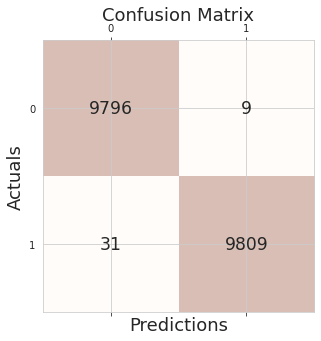

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Hasil

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

Accuracy: 0.997964
Precision: 0.999083
Recall: 0.996850
